### homework 1: COVID-19 Cases Prediction (regression)

### download data
you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace

In [167]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

### import some packages

In [168]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# for data preprocess
import numpy as np
import csv
import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed)

### some utilities
you do not need to modify this part.

In [169]:
def get_device():
  ''' get device (if GPU is available, use GPU) '''
  return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
  ''' plot learning curve of your DNN (train & dev loss) '''
  total_steps = len(loss_record['train'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
  figure(figsize=(6, 4))
  plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
  plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
  plt.ylim(0.0, 5.)
  plt.xlabel('training steps')
  plt.ylabel('MSE loss')
  plt.title('learning curve of {}'.format(title))
  plt.legend()
  plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
  ''' plot prediction of your DNN '''
  if preds is None or targets is None:
    model.eval()
    preds, targets = [], []
    for x, y in dv_set:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        pred = model(x)
        preds.append(pred.detach().cpu())
        targets.append(y.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()

  figure(figsize=(5, 5))
  plt.scatter(targets, preds, c='r', alpha=0.5)
  plt.plot([-0.2, lim], [-0.2, lim], c='b')
  plt.xlim(-0.2, lim)
  plt.ylim(-0.2, lim)
  plt.xlabel('ground truth value')
  plt.ylabel('predicted value')
  plt.title('ground truth v.s. prediction')
  plt.show()

### preprocess
we have three kinds of datasets:
* train: for training
* dev: for validation
* test: for testing (w/o target value)

### Dataset
the COVID19Dataset below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

finishing TODO below might make you pass medium baseline

In [170]:
class COVID19Dataset(Dataset):
  ''' Dataset for loading and preprocessing the COVID19 dataset '''

  def __init__(self,
               path,
               mode='train',
               target_only=False):
    self.mode = mode

    # read data into numpy arrays
    with open(path, 'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:, 1:].astype(float)

    if not target_only:
      feats = list(range(93))
    else:
      # TODO: using 40 states & 2 tested_positive features (indices = 57 & 75)
      pass

    if mode == 'test':
      # testing data
      # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
      data = data[:, feats]
      self.data = torch.FloatTensor(data)
    else:
      # training data (train/dev sets)
      # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
      target = data[:, -1]
      data = data[:, feats]

      # splitting training data into train & dev sets
      if mode == 'train':
        indices = [i for i in range(len(data)) if i % 10 != 0]
      elif mode == 'dev':
        indices = [i for i in range(len(data)) if i % 10 == 0]

      # convert data into PyTorch tensors
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])

    # normalize features (you may remove this part to see what will happen)
    self.data[:, 40:] = \
        (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
        / self.data[:, 40:].std(dim=0, keepdim=True)

    self.dim = self.data.shape[1]

    print('finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
          .format(mode, len(self.data), self.dim))

  def __getitem__(self, index):
    if self.mode in ['train', 'dev']:
      return self.data[index], self.target[index]
    else:
      return self.data[index]

  def __len__(self):
    return len(self.data)

### DataLoader
a DataLoader loads data from a given Dataset into batches.

In [171]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
  ''' generates a dataset, then is put into a dataloader '''
  dataset = COVID19Dataset(path, mode=mode, target_only=target_only)
  dataloader = DataLoader(dataset, batch_size,
                          shuffle=(mode == 'train'), drop_last=False,
                          num_workers=n_jobs, pin_memory=True)
  return dataloader

### deep neural network
`NeuralNet` is an nn.Module designed for regression. 

the DNN consists of 2 fully-connected layers with `ReLU` activation. 

this module also included a function `cal_loss` for calculating loss.

In [172]:
class NeuralNet(nn.Module):
  ''' a simple fully-connected deep neural network '''

  def __init__(self, input_dim):
    super().__init__()

    # define your neural network here
    # TODO: how to modify this model to achieve better performance?
    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

    # mean squared error loss
    self.criterion = nn.MSELoss(reduction='mean')

  def forward(self, x):
    ''' given input of size (batch_size x input_dim), compute output of the network '''
    return self.net(x).squeeze(1)

  def cal_loss(self, pred, target):
    ''' calculate loss '''
    # TODO: you may implement L1/L2 regularization here
    return self.criterion(pred, target)

### training

In [173]:
def train(tr_set, dv_set, model, config, device):
  ''' DNN training '''

  n_epochs = config['n_epochs']  # maximum number of epochs

  # setup optimizer
  optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas'])

  min_mse = 1000.
  loss_record = {'train': [], 'dev': []}      # for recording training loss
  early_stop_cnt = 0
  epoch = 0
  while epoch < n_epochs:
    model.train()                           # set model to training mode
    for x, y in tr_set:                     # iterate through the dataloader
      optimizer.zero_grad()                 # set gradient to zero
      # move data to device (cpu/cuda)
      x, y = x.to(device), y.to(device)
      # forward pass (compute output)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)    # compute loss
      mse_loss.backward()                   # compute gradient (backpropagation)
      optimizer.step()                      # update model with optimizer
      loss_record['train'].append(mse_loss.detach().cpu().item())

    # after each epoch, test your model on the validation (development) set.
    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      # save model if your model improved
      min_mse = dev_mse
      print('saving model (epoch = {:4d}, loss = {:.4f})'
            .format(epoch + 1, min_mse))
      # save model to specified path
      torch.save(model.state_dict(), config['save_path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1

    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      # stop training if your model stops improving for "config['early_stop']" epochs.
      break

  print('finished training after {} epochs'.format(epoch))
  return min_mse, loss_record

### validation

In [174]:
def dev(dv_set, model, device):
  model.eval()                                # set model to evalutation mode
  total_loss = 0
  for x, y in dv_set:                         # iterate through the dataloader
    # move data to device (cpu/cuda)
    x, y = x.to(device), y.to(device)
    with torch.no_grad():                   # disable gradient calculation
      # forward pass (compute output)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)    # compute loss
    total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
  # compute averaged loss
  total_loss = total_loss / len(dv_set.dataset)

  return total_loss

### testing

In [175]:
def test(tt_set, model, device):
  model.eval()                                # set model to evalutation mode
  preds = []
  for x in tt_set:                            # iterate through the dataloader
    # move data to device (cpu/cuda)
    x = x.to(device)
    with torch.no_grad():                   # disable gradient calculation
      # forward pass (compute output)
      pred = model(x)
      preds.append(pred.detach().cpu())     # collect prediction
  # concatenate all predictions and convert to a numpy array
  preds = torch.cat(preds, dim=0).numpy()
  return preds

### setup hyper-parameters
config contains hyper-parameters for training and the path to save your model

In [176]:
# get the current available device ('cpu' or 'cuda')
device = get_device()
# the trained model will be saved to ./models/
os.makedirs('models', exist_ok=True)
# TODO: using 40 states & 2 tested_positive features
target_only = False

# TODO: how to tune these hyper-parameters to improve your model's performance?
config = {
  'n_epochs': 3000,                # maximum number of epochs
  'batch_size': 270,               # mini-batch size for dataloader
  # optimization algorithm (optimizer in torch.optim)
  'optimizer': 'SGD',
  'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
    'lr': 0.001,                   # learning rate of SGD
    'momentum': 0.9                # momentum for SGD
  },
  # early stopping epochs (the number epochs since your model's last improvement)
  'early_stop': 200,
  'save_path': 'models/model.pth'  # your model will be saved here
}

### load data and model

In [177]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [178]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # construct model and move to device

### start training!

In [179]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

saving model (epoch =    1, loss = 78.8524)
saving model (epoch =    2, loss = 37.6170)
saving model (epoch =    3, loss = 26.1203)
saving model (epoch =    4, loss = 16.1862)
saving model (epoch =    5, loss = 9.7153)
saving model (epoch =    6, loss = 6.3701)
saving model (epoch =    7, loss = 5.1802)
saving model (epoch =    8, loss = 4.4255)
saving model (epoch =    9, loss = 3.8009)
saving model (epoch =   10, loss = 3.3691)
saving model (epoch =   11, loss = 3.0943)
saving model (epoch =   12, loss = 2.8176)
saving model (epoch =   13, loss = 2.6274)
saving model (epoch =   14, loss = 2.4542)
saving model (epoch =   15, loss = 2.3012)
saving model (epoch =   16, loss = 2.1766)
saving model (epoch =   17, loss = 2.0641)
saving model (epoch =   18, loss = 1.9399)
saving model (epoch =   19, loss = 1.8978)
saving model (epoch =   20, loss = 1.7950)
saving model (epoch =   21, loss = 1.7164)
saving model (epoch =   22, loss = 1.6455)
saving model (epoch =   23, loss = 1.5912)
saving 

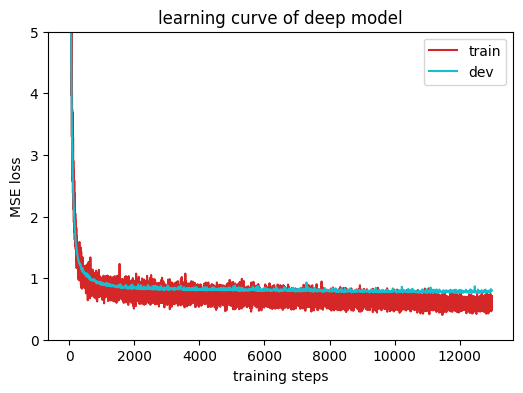

In [180]:
plot_learning_curve(model_loss_record, title='deep model')

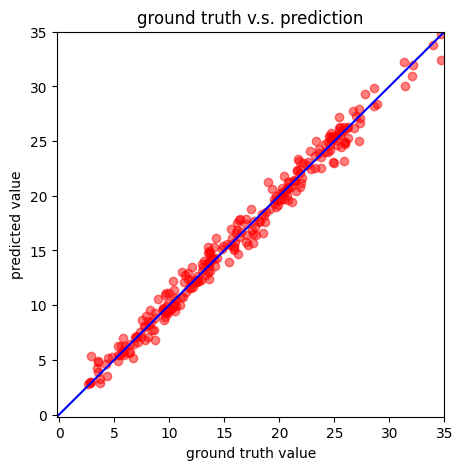

In [181]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
# load your best model
ckpt = torch.load(config['save_path'], map_location='cpu', weights_only=True)
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # show prediction on the validation set

### testing
the predictions of your model on testing set will be stored at `pred.csv`

In [182]:
def save_pred(preds, file):
  ''' save predictions to specified file '''
  print('saving results to {}'.format(file))
  with open(file, 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(preds):
      writer.writerow([i, p])


preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

saving results to pred.csv


### download
run this block to download the `pred.csv` by clicking

In [183]:
from IPython.display import FileLink
FileLink(r'pred.csv')

/root/remy/learncode/dl/regression/pred.csv